# Preparación de la data de entrenamiento

Para la preparación de la data de entrenamiento necesitamos obtener pares de oraciones (frase en inglés. frase en español) si se va a hacer un traductor de inglés al español por ejemplo.

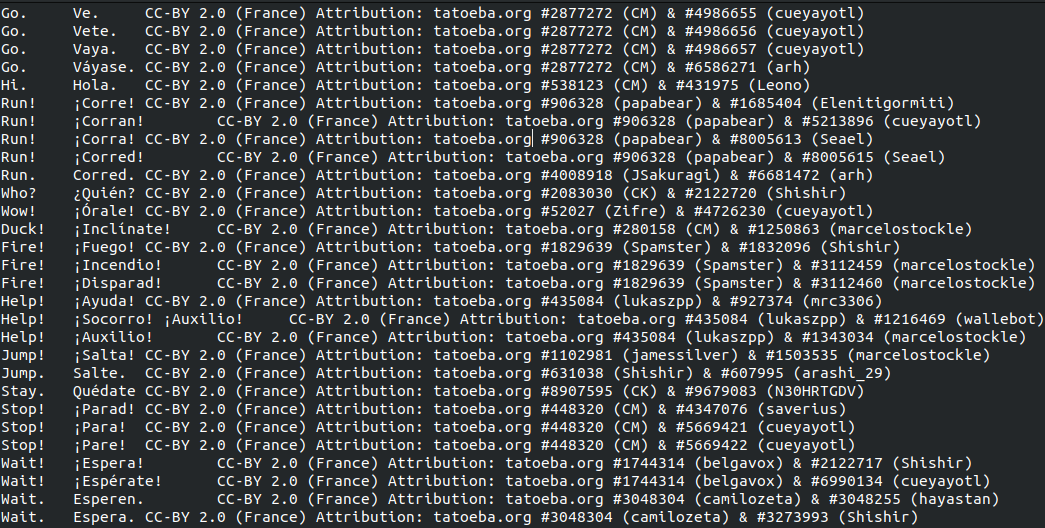

En la imágen anterior se muestra una data antes de ser preparada, esta data servirá para hacer un traductor del inglés al español.

Como nuestro objetivo es hacer un chatbot nosotros necesitamos pares de oraciones con una pregunta y respuesta, con pregunta nos referimos al usuario activo en la conversación y la respuesta es la manera en que esperamos que responda a la conversación.


El proceso completo para preparar los datos es:

* Lea el archivo de texto y divídelo en líneas, divida las líneas en pares
* Normalizar texto, filtrar por longitud y contenido
* Haga listas de palabras a partir de oraciones en pares

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


### Preprocesamiento de la data en JSON

In [ ]:
%ls

drive/  sample_data/


In [ ]:
!pip install requests

Importamos la librerias

In [ ]:
import requests
import json

In [ ]:
resp = requests.get('https://raw.githubusercontent.com/ccasimiro88/TranslateAlignRetrieve/master/SQuAD-es-v2.0/dev-v2.0-es_small.json')
data = json.loads(resp.text)["data"]

Temas de las preguntas

In [ ]:
for i in data:
  print(i["title"])

Normandos
Complejidad computacional _ teoría
Southern _ California
Sky _ (Reino Unido)
Victoria _ (Australia)
Hugonotes
Motor
Oxígeno
1973: Crisis del petróleo
Ley Europea
Selva Amazónica
Ctenophora
Fresno, California
Conmutación de paquetes
Muerte negra
Geología
Farmacia
Desobediencia civil
Construcción
Escuela privada
Universidad
Jacksonville, Florida.
Desigualdad económica
Universidad de Chicago
Dinastía Yuan
Sistema inmune
Intergovernmental _ Panel _ on _ Climate _ Change
Número Prime
Rin
Parlamento escocés
El islamismo
Imperialismo
Varsovia
Guerra franco-india
Fuerza


Pasamos a pares de lineas pregunta - respuesta

Cada "data" es un tema, contiene un conjunto de "paragraphs". En cada "paragraphs" tenemos un contexto "context" y un conjunto de preguntas y respuestas "qas"

In [ ]:
#with open('json', 'w') as f:
#    f.write(resp.text)
flag = False
with open('cultura_general_1', 'w') as f:
  for tema in data:
    # print(tema["paragraphs"])
    #for j in range(10):
    for context in tema["paragraphs"]:
      for qas in context["qas"]:
        #    print("--",qas["question"])
        
        for answer in qas["answers"]:
        #      print(answer["text"])
          if flag:
            break
          if len(answer["text"]) > 0:
            f.write(qas["question"] + "\t" + answer["text"] + "\n")
          #if len(answer["text"]) > 0:
          #  print(answer["text"])
          flag = True
        flag = False
            

El formato del archivo que obtenemos del preprocesamiento consiste en lineas de texto, en cada línea hay una pregunta y una respuesta separadas por un tab "\t". Como por ejemplo: en que pais se encuentra normandia ?\tfrancia

### Preprocesamiento de la data cualtura general 2 (Freider)

In [ ]:
fi = open("data_freider.txt", "w")

with open('cultura.txt', 'r') as f:
  
  for l in f:
    
    # print(line1[0].split("^[0-9]+\."))
    #print(line1[0].replace("^\d+$", ""))
    fi.write(re.sub(r"^\d+\. ","", l))
    
fi.close()
  #f.write(qas["question"] + "\t" + answer["text"] + "\n")
          

### Preprocesamiento Rosa


In [ ]:

with open('DAILYD.txt', 'r') as f:
  limit = 10
  line = 0
  for l in f:
    l
    print(l)
    line +=1
    if line >= limit:
      break

La cocina apesta. 	 Voy a tirar la basura . 

Dick , ¿qué tal tomar un café para esta noche? 	 ¿Café? Honestamente no me gusta ese tipo de cosas. 

 ¿Café? Honestamente no me gusta ese tipo de cosas. 	 Vamos, al menos puedes probar un poco, además de tu cigarrillo. 

 Vamos, al menos puedes probar un poco, además de tu cigarrillo. 	 ¿Qué tiene de malo? Cigarrillo es lo que me vuelvo loco por . 

¿Las cosas siguen yendo mal con su invitado? 	 Empeorando. Ahora me está comiendo fuera de casa y de casa. He intentado hablar con él, pero todo va en un oído y fuera del otro . Se hace en casa, lo cual está bien. Pero lo que realmente me consigue es que ayer entró en la sala de estar en la materia prima y yo tenía compañía de más de ! Esa fue la gota que colmó el vaso . 

 Empeorando. Ahora me está comiendo fuera de casa y de casa. He intentado hablar con él, pero todo va en un oído y fuera del otro . Se hace en casa, lo cual está bien. Pero lo que realmente me consigue es que ayer entró en la

### Procesamiento de la data de la data

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math


In [3]:
# Default word tokens

len_sentence_question = 0
len_sentence_answer = 0
max_len_question = 0
max_len_answer = 0

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [4]:
MAX_LENGTH = 30 # Maximum sentence length to consider



# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?0-9]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])

        
        voc.addSentence(pair[1])
        

    print("Counted words:", voc.num_words)
    
    
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = "./"
datafile = "final.txt"
corpus = "./"
corpus_name = "data_s2s"
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")

for pair in pairs[:10]:
    print(pair)


Start preparing training data ...
Reading lines...
Read 96939 sentence pairs
Trimmed to 90354 sentence pairs
Counting words...
Counted words: 33570

pairs:
['la cocina apesta .', 'voy a tirar la basura .']
['dick que tal tomar un cafe para esta noche ?', 'cafe ? honestamente no me gusta ese tipo de cosas .']
['cafe ? honestamente no me gusta ese tipo de cosas .', 'vamos al menos puedes probar un poco ademas de tu cigarrillo .']
['vamos al menos puedes probar un poco ademas de tu cigarrillo .', 'que tiene de malo ? cigarrillo es lo que me vuelvo loco por .']
['te importaria esperar un rato ?', 'bueno cuanto tiempo sera ?']
['bueno cuanto tiempo sera ?', 'no estoy seguro . pero voy a conseguir una mesa lista tan rapido como pueda .']
['vas a ir a la fiesta anual ? puedo llevarte si necesitas uno .', 'muchas gracias . ese es el favor que iba a pedirte .']
['muchas gracias . ese es el favor que iba a pedirte .', 'el placer es mio .']
['no es el mejor instructor ? creo que esta tan caliente

In [5]:
print(len(pairs))

90354


### Divición del conjunto de entrenamiento

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs[0], pairs[1], test_size=0.33, random_state=42)

In [8]:
pairs

['la cocina apesta .', 'voy a tirar la basura .']

## Preparación de la data

In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[   56,    25,    25,    25,    25],
        [   55,   384,    66,   166,   310],
        [    6,   588,   214, 13175,   311],
        [  354,  2359,    24,    16,   111],
        [   58,    26,   162,     2,     2],
        [  402,   166,    16,     0,     0],
        [   34,   346,     2,     0,     0],
        [   85,    16,     0,     0,     0],
        [   16,     2,     0,     0,     0],
        [    2,     0,     0,     0,     0]])
lengths: tensor([10,  9,  7,  5,  5])
target_variable: tensor([[  156,    56,  1553,   119,    25],
        [ 2748,   166,   795,   465,    41],
        [    6,   937,  4060,  1455,  2830],
        [    2,   183,   528,    26,    16],
        [    0,  1487,     3, 13176,     2],
        [    0,     6,  3052,     2,     0],
        [    0,     2,  4040,     0,     0],
        [    0,     0,  4041,     0,     0],
        [    0,     0,    16,     0,     0],
        [    0,     0,     2,     0,     0]])
mask: tensor([[ True,  True

In [ ]:
batch_size = 64
training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

In [ ]:
print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

train_size = len(pairs) * 80 // 100 
entrenamiento = pairs[:train_size]
prueba = pairs[train_size:]

dataset = {
    'train': ,
    'test': 
}

len(dataset['train']), len(dataset['test'])
